# Actor-Critic

## 1. 原理

在 Actor-Critic 算法中，策略梯度 $g(s, a) = Q_\pi(s, a) \cdot \nabla_\theta \ln \pi(a \mid s; \theta)$，其中 $Q_\pi(s, a)$ 使用价值网络 $q(s, a; w)$ 来近似。Actor 网络决定策略，而 Critic 网络估计策略的价值。

## 2. 训练流程

设策略网络 (Actor)、价值网络 (Critic) 和目标网络 (Target Critic) 的当前参数分别为 $\theta_{now}$, $w_{now}$ 和 $w_{now}^-$。

(1) 在当前状态 $s_t$，Actor 网络根据策略进行动作选择并执行，得到 $a_t \sim \pi(\cdot \mid s_t; \theta_{now})$，同时观测到奖励 $r_t$ 和新状态 $s_{t+1}$；

(2) Actor 网络在新状态 $s_{t+1}$ 上选择下一个动作 $\tilde{a}_{t+1} = \pi(\cdot \mid s_{t+1}; \theta_{now})$，但不执行该动作；

(3) Critic 网络对当前动作进行评分，得到 $\hat{q}_t = q(s_t, a_t; w_{now})$；

(4) 目标网络对下一个状态和动作评分，得到 $\hat{q}_{t+1} = q(s_{t+1}, \tilde{a}_{t+1}; w_{now}^-)$；

(5) 计算 TD 目标和 TD 误差：
   $$ \hat{y}_t = r_t + \gamma \cdot \hat{q}_{t+1} $$
   $$ \delta_t = \hat{y}_t - \hat{q}_t $$

(6) 更新 Critic 网络：
   $$ w_{new} = w_{now} - \alpha \cdot \delta_t \cdot \nabla_w q(s_t, a_t; w_{now}) $$

(7) 使用优势函数更新 Actor 网络：
   $$ \theta_{new} = \theta_{now} + \beta \cdot \hat{q}_t \cdot \nabla_{\theta} \ln \pi(a_t \mid s_t; \theta_{now}) $$

(8) 目标网络软更新（可在特定间隔执行）：
   $$ w_{new}^- = \tau \cdot w_{new} + (1 - \tau) \cdot w_{now}^- $$

#### 2.1. 备注

- **TD 目标 (TD Target)**：是用于更新 Critic 网络的目标，表示期望的未来奖励。
- **TD 误差 (TD Error)**：表示当前 Critic 估计的值和 TD 目标的差异，用于更新 Critic 网络。


In [1]:
# 导入库
import os
import gym
import argparse
import numpy as np

import torch
from torch import nn
import torch.nn.functional as F
from torch.distributions import Categorical
from torch.utils.tensorboard import SummaryWriter

In [2]:
# 定义价值网络
class ValueNet(nn.Module):
    def __init__(self, state_size):
        super().__init__()
        self.fc1 = nn.Linear(state_size, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
    
    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [3]:
# 定义策略网络
class PolicyNet(nn.Module):
    def __init__(self, state_size, num_actions):
        super().__init__()
        self.fc1 = nn.Linear(state_size, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, num_actions)
        
    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        prob = F.softmax(x, dim=-1)
        return prob

In [4]:
# 定义ActorCritic类
class ActorCritic:
    def __init__(self, state_size, num_actions, discount, device):
        self.discount = discount
        self.device = device
        self.actor = PolicyNet(state_size, num_actions).to(device)
        self.critic = ValueNet(state_size).to(device)
        self.target = ValueNet(state_size).to(device)
        self.target.load_state_dict(self.critic.state_dict())
        
    def get_action(self, state):
        # state: (state_size,)
        # prob: (state_size,)
        prob = self.actor(state)
        m = Categorical(prob)
        action = m.sample()
        log_prob = m.log_prob(action)
        return action.item(), log_prob
    
    def compute_loss(self, bs, blogp, br, bd, bns):
        # bs, bns: (batch_size, state_size)
        # blogp, br, bd: (batch_size,)
        # current_value: (batch_size,)
        current_value = self.critic(bs).squeeze()
        # next_value: (batch_size,)
        next_value = self.target(bns).squeeze()
        # target_value: (batch_size,)
        target_value = br + self.discount * (1 - bd) * next_value
        policy_loss = -(blogp * target_value.detach()).mean()
        value_loss = F.mse_loss(current_value, target_value.detach())
        return policy_loss, value_loss
        
        
    def soft_update(self, tau=0.01):
        for target_param, param in zip(self.target.parameters(), self.critic.parameters()):
            target_param.data.copy_(target_param.data * (1 - tau) + param * tau)

In [5]:
# 训练
def train(args, env):
    agent = ActorCritic(args.state_size, args.num_actions, args.discount, args.device)
    value_optimizer = torch.optim.Adam(agent.critic.parameters(), lr=args.value_lr)
    policy_optimizer = torch.optim.Adam(agent.actor.parameters(), lr=args.policy_lr)
    
    episode_reward = 0
    episode_length = 0
    episode_num = 0
    max_episode_reward = float('-inf')
    
    agent.actor.train()
    agent.critic.train()
    state, _ = env.reset()
    writer = SummaryWriter()
    save_path = os.path.join(args.output_dir, 'model.bin')
    
    for i in range(args.max_steps):
        action, log_prob = agent.get_action(torch.tensor(state, dtype=torch.float32, device=args.device))
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        episode_reward += reward
        episode_length += 1
        
        reward_tensor = torch.tensor([reward], dtype=torch.float32).to(args.device)
        state_tensor = torch.tensor(state, dtype=torch.float32).to(args.device)
        next_state_tensor = torch.tensor(next_state, dtype=torch.float32).to(args.device)
        done_tensor = torch.tensor([done], dtype=torch.float32).to(args.device)
        
        policy_loss, value_loss = agent.compute_loss(state_tensor, log_prob, reward_tensor, done_tensor, next_state_tensor)
        
        policy_optimizer.zero_grad()
        policy_loss.backward()
        policy_optimizer.step()
        
        value_optimizer.zero_grad()
        value_loss.backward()
        value_optimizer.step()
        
        state = next_state
        
        if done:
            if episode_reward >= max_episode_reward:
                max_episode_reward = episode_reward
                torch.save(agent.actor.state_dict(), save_path)
                
            writer.add_scalar('Maximum reward', max_episode_reward, episode_num)
            writer.add_scalar('Episode reward', episode_reward, episode_num)
            writer.add_scalar('Episode length', episode_length, episode_num)
            print(f'step = {i}, reward = {episode_reward:.0f}, length = {episode_length}, max reward = {max_episode_reward}')
            
            episode_reward = 0
            episode_length = 0
            episode_num += 1
            agent.soft_update()
            state, _ = env.reset()
            
    writer.close()

In [6]:
# 测试
def eval(args, env):
    agent = ActorCritic(args.state_size, args.num_actions, args.discount, args.device)
    model_path = os.path.join(args.output_dir, 'model.bin')
    agent.actor.load_state_dict(torch.load(model_path))
    agent.actor.to(args.device)
    agent.actor.eval()
    
    episode_reward = 0
    episode_length = 0
    state, _ = env.reset()
    for _ in range(5000):
        action, _ = agent.get_action(torch.tensor(state, dtype=torch.float32, device=args.device))
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        episode_reward += reward
        episode_length += 1
        state = next_state
        
        if done:
            state, _ = env.reset()
            print(f'episode reward = {episode_reward:.0f}, episode length = {episode_length}')
            episode_reward = 0
            episode_length = 0

In [7]:
# 运行
args = argparse.Namespace()
args.env = 'CartPole-v1'
args.state_size = 4
args.num_actions = 2
args.discount = 0.99
args.max_steps = int(2e5)
args.policy_lr = 1e-4
args.value_lr = 1e-3
args.output_dir = 'output'
if torch.cuda.is_available():
    args.device = torch.device('cuda')
else:
    args.device = torch.device('cpu')
    
os.makedirs(args.output_dir, exist_ok=True)
    
env = gym.make(args.env)
env.reset(seed=42)
env.action_space.seed(42)
np.random.seed(42)
torch.manual_seed(42)
if args.device == torch.device('cuda'):
    torch.cuda.manual_seed(42)
print('Training started...')
train(args, env)
print('Training completed!')

print('Evaluation started...')
eval(args, env)
print('Evaluation completed!')

Training started...
step = 21, reward = 22, length = 22, max reward = 22.0
step = 49, reward = 28, length = 28, max reward = 28.0
step = 70, reward = 21, length = 21, max reward = 28.0
step = 85, reward = 15, length = 15, max reward = 28.0
step = 107, reward = 22, length = 22, max reward = 28.0
step = 134, reward = 27, length = 27, max reward = 28.0
step = 153, reward = 19, length = 19, max reward = 28.0
step = 166, reward = 13, length = 13, max reward = 28.0


/Users/xavier/PythonCode/venv/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


step = 196, reward = 30, length = 30, max reward = 30.0
step = 225, reward = 29, length = 29, max reward = 30.0
step = 253, reward = 28, length = 28, max reward = 30.0
step = 281, reward = 28, length = 28, max reward = 30.0
step = 314, reward = 33, length = 33, max reward = 33.0
step = 331, reward = 17, length = 17, max reward = 33.0
step = 344, reward = 13, length = 13, max reward = 33.0
step = 375, reward = 31, length = 31, max reward = 33.0
step = 396, reward = 21, length = 21, max reward = 33.0
step = 416, reward = 20, length = 20, max reward = 33.0
step = 434, reward = 18, length = 18, max reward = 33.0
step = 453, reward = 19, length = 19, max reward = 33.0
step = 471, reward = 18, length = 18, max reward = 33.0
step = 484, reward = 13, length = 13, max reward = 33.0
step = 495, reward = 11, length = 11, max reward = 33.0
step = 506, reward = 11, length = 11, max reward = 33.0
step = 560, reward = 54, length = 54, max reward = 54.0
step = 574, reward = 14, length = 14, max reward

step = 3507, reward = 10, length = 10, max reward = 89.0
step = 3528, reward = 21, length = 21, max reward = 89.0
step = 3542, reward = 14, length = 14, max reward = 89.0
step = 3588, reward = 46, length = 46, max reward = 89.0
step = 3605, reward = 17, length = 17, max reward = 89.0
step = 3638, reward = 33, length = 33, max reward = 89.0
step = 3655, reward = 17, length = 17, max reward = 89.0
step = 3674, reward = 19, length = 19, max reward = 89.0
step = 3689, reward = 15, length = 15, max reward = 89.0
step = 3720, reward = 31, length = 31, max reward = 89.0
step = 3737, reward = 17, length = 17, max reward = 89.0
step = 3753, reward = 16, length = 16, max reward = 89.0
step = 3768, reward = 15, length = 15, max reward = 89.0
step = 3780, reward = 12, length = 12, max reward = 89.0
step = 3802, reward = 22, length = 22, max reward = 89.0
step = 3816, reward = 14, length = 14, max reward = 89.0
step = 3830, reward = 14, length = 14, max reward = 89.0
step = 3844, reward = 14, lengt

step = 7041, reward = 50, length = 50, max reward = 89.0
step = 7156, reward = 115, length = 115, max reward = 115.0
step = 7195, reward = 39, length = 39, max reward = 115.0
step = 7215, reward = 20, length = 20, max reward = 115.0
step = 7250, reward = 35, length = 35, max reward = 115.0
step = 7281, reward = 31, length = 31, max reward = 115.0
step = 7314, reward = 33, length = 33, max reward = 115.0
step = 7329, reward = 15, length = 15, max reward = 115.0
step = 7341, reward = 12, length = 12, max reward = 115.0
step = 7369, reward = 28, length = 28, max reward = 115.0
step = 7393, reward = 24, length = 24, max reward = 115.0
step = 7408, reward = 15, length = 15, max reward = 115.0
step = 7422, reward = 14, length = 14, max reward = 115.0
step = 7443, reward = 21, length = 21, max reward = 115.0
step = 7454, reward = 11, length = 11, max reward = 115.0
step = 7475, reward = 21, length = 21, max reward = 115.0
step = 7490, reward = 15, length = 15, max reward = 115.0
step = 7516, 

step = 10521, reward = 29, length = 29, max reward = 115.0
step = 10560, reward = 39, length = 39, max reward = 115.0
step = 10571, reward = 11, length = 11, max reward = 115.0
step = 10591, reward = 20, length = 20, max reward = 115.0
step = 10621, reward = 30, length = 30, max reward = 115.0
step = 10658, reward = 37, length = 37, max reward = 115.0
step = 10685, reward = 27, length = 27, max reward = 115.0
step = 10708, reward = 23, length = 23, max reward = 115.0
step = 10731, reward = 23, length = 23, max reward = 115.0
step = 10760, reward = 29, length = 29, max reward = 115.0
step = 10794, reward = 34, length = 34, max reward = 115.0
step = 10810, reward = 16, length = 16, max reward = 115.0
step = 10822, reward = 12, length = 12, max reward = 115.0
step = 10878, reward = 56, length = 56, max reward = 115.0
step = 10903, reward = 25, length = 25, max reward = 115.0
step = 10925, reward = 22, length = 22, max reward = 115.0
step = 10980, reward = 55, length = 55, max reward = 115

step = 14265, reward = 51, length = 51, max reward = 115.0
step = 14299, reward = 34, length = 34, max reward = 115.0
step = 14347, reward = 48, length = 48, max reward = 115.0
step = 14394, reward = 47, length = 47, max reward = 115.0
step = 14422, reward = 28, length = 28, max reward = 115.0
step = 14458, reward = 36, length = 36, max reward = 115.0
step = 14473, reward = 15, length = 15, max reward = 115.0
step = 14505, reward = 32, length = 32, max reward = 115.0
step = 14535, reward = 30, length = 30, max reward = 115.0
step = 14550, reward = 15, length = 15, max reward = 115.0
step = 14598, reward = 48, length = 48, max reward = 115.0
step = 14611, reward = 13, length = 13, max reward = 115.0
step = 14637, reward = 26, length = 26, max reward = 115.0
step = 14735, reward = 98, length = 98, max reward = 115.0
step = 14750, reward = 15, length = 15, max reward = 115.0
step = 14772, reward = 22, length = 22, max reward = 115.0
step = 14814, reward = 42, length = 42, max reward = 115

step = 18913, reward = 76, length = 76, max reward = 120.0
step = 18952, reward = 39, length = 39, max reward = 120.0
step = 18988, reward = 36, length = 36, max reward = 120.0
step = 19036, reward = 48, length = 48, max reward = 120.0
step = 19054, reward = 18, length = 18, max reward = 120.0
step = 19100, reward = 46, length = 46, max reward = 120.0
step = 19123, reward = 23, length = 23, max reward = 120.0
step = 19197, reward = 74, length = 74, max reward = 120.0
step = 19211, reward = 14, length = 14, max reward = 120.0
step = 19237, reward = 26, length = 26, max reward = 120.0
step = 19253, reward = 16, length = 16, max reward = 120.0
step = 19291, reward = 38, length = 38, max reward = 120.0
step = 19332, reward = 41, length = 41, max reward = 120.0
step = 19375, reward = 43, length = 43, max reward = 120.0
step = 19390, reward = 15, length = 15, max reward = 120.0
step = 19462, reward = 72, length = 72, max reward = 120.0
step = 19485, reward = 23, length = 23, max reward = 120

step = 24523, reward = 95, length = 95, max reward = 146.0
step = 24543, reward = 20, length = 20, max reward = 146.0
step = 24599, reward = 56, length = 56, max reward = 146.0
step = 24640, reward = 41, length = 41, max reward = 146.0
step = 24679, reward = 39, length = 39, max reward = 146.0
step = 24712, reward = 33, length = 33, max reward = 146.0
step = 24747, reward = 35, length = 35, max reward = 146.0
step = 24766, reward = 19, length = 19, max reward = 146.0
step = 24786, reward = 20, length = 20, max reward = 146.0
step = 24806, reward = 20, length = 20, max reward = 146.0
step = 24825, reward = 19, length = 19, max reward = 146.0
step = 24873, reward = 48, length = 48, max reward = 146.0
step = 24978, reward = 105, length = 105, max reward = 146.0
step = 24996, reward = 18, length = 18, max reward = 146.0
step = 25028, reward = 32, length = 32, max reward = 146.0
step = 25064, reward = 36, length = 36, max reward = 146.0
step = 25083, reward = 19, length = 19, max reward = 1

step = 32171, reward = 72, length = 72, max reward = 158.0
step = 32237, reward = 66, length = 66, max reward = 158.0
step = 32266, reward = 29, length = 29, max reward = 158.0
step = 32324, reward = 58, length = 58, max reward = 158.0
step = 32359, reward = 35, length = 35, max reward = 158.0
step = 32427, reward = 68, length = 68, max reward = 158.0
step = 32496, reward = 69, length = 69, max reward = 158.0
step = 32570, reward = 74, length = 74, max reward = 158.0
step = 32601, reward = 31, length = 31, max reward = 158.0
step = 32822, reward = 221, length = 221, max reward = 221.0
step = 32894, reward = 72, length = 72, max reward = 221.0
step = 32982, reward = 88, length = 88, max reward = 221.0
step = 33031, reward = 49, length = 49, max reward = 221.0
step = 33068, reward = 37, length = 37, max reward = 221.0
step = 33119, reward = 51, length = 51, max reward = 221.0
step = 33168, reward = 49, length = 49, max reward = 221.0
step = 33208, reward = 40, length = 40, max reward = 2

step = 39420, reward = 37, length = 37, max reward = 221.0
step = 39452, reward = 32, length = 32, max reward = 221.0
step = 39547, reward = 95, length = 95, max reward = 221.0
step = 39596, reward = 49, length = 49, max reward = 221.0
step = 39642, reward = 46, length = 46, max reward = 221.0
step = 39698, reward = 56, length = 56, max reward = 221.0
step = 39742, reward = 44, length = 44, max reward = 221.0
step = 39801, reward = 59, length = 59, max reward = 221.0
step = 39833, reward = 32, length = 32, max reward = 221.0
step = 39880, reward = 47, length = 47, max reward = 221.0
step = 39916, reward = 36, length = 36, max reward = 221.0
step = 39976, reward = 60, length = 60, max reward = 221.0
step = 40114, reward = 138, length = 138, max reward = 221.0
step = 40248, reward = 134, length = 134, max reward = 221.0
step = 40332, reward = 84, length = 84, max reward = 221.0
step = 40388, reward = 56, length = 56, max reward = 221.0
step = 40426, reward = 38, length = 38, max reward =

step = 49611, reward = 70, length = 70, max reward = 221.0
step = 49752, reward = 141, length = 141, max reward = 221.0
step = 49995, reward = 243, length = 243, max reward = 243.0
step = 50184, reward = 189, length = 189, max reward = 243.0
step = 50303, reward = 119, length = 119, max reward = 243.0
step = 50349, reward = 46, length = 46, max reward = 243.0
step = 50501, reward = 152, length = 152, max reward = 243.0
step = 50609, reward = 108, length = 108, max reward = 243.0
step = 50778, reward = 169, length = 169, max reward = 243.0
step = 50890, reward = 112, length = 112, max reward = 243.0
step = 51025, reward = 135, length = 135, max reward = 243.0
step = 51102, reward = 77, length = 77, max reward = 243.0
step = 51155, reward = 53, length = 53, max reward = 243.0
step = 51224, reward = 69, length = 69, max reward = 243.0
step = 51354, reward = 130, length = 130, max reward = 243.0
step = 51435, reward = 81, length = 81, max reward = 243.0
step = 51690, reward = 255, length =

step = 65169, reward = 207, length = 207, max reward = 402.0
step = 65433, reward = 264, length = 264, max reward = 402.0
step = 65678, reward = 245, length = 245, max reward = 402.0
step = 66040, reward = 362, length = 362, max reward = 402.0
step = 66258, reward = 218, length = 218, max reward = 402.0
step = 66394, reward = 136, length = 136, max reward = 402.0
step = 66467, reward = 73, length = 73, max reward = 402.0
step = 66752, reward = 285, length = 285, max reward = 402.0
step = 66899, reward = 147, length = 147, max reward = 402.0
step = 67094, reward = 195, length = 195, max reward = 402.0
step = 67249, reward = 155, length = 155, max reward = 402.0
step = 67436, reward = 187, length = 187, max reward = 402.0
step = 67716, reward = 280, length = 280, max reward = 402.0
step = 68008, reward = 292, length = 292, max reward = 402.0
step = 68159, reward = 151, length = 151, max reward = 402.0
step = 68359, reward = 200, length = 200, max reward = 402.0
step = 68617, reward = 258

step = 90333, reward = 90, length = 90, max reward = 500.0
step = 90482, reward = 149, length = 149, max reward = 500.0
step = 90617, reward = 135, length = 135, max reward = 500.0
step = 90782, reward = 165, length = 165, max reward = 500.0
step = 90876, reward = 94, length = 94, max reward = 500.0
step = 90957, reward = 81, length = 81, max reward = 500.0
step = 91106, reward = 149, length = 149, max reward = 500.0
step = 91267, reward = 161, length = 161, max reward = 500.0
step = 91487, reward = 220, length = 220, max reward = 500.0
step = 91680, reward = 193, length = 193, max reward = 500.0
step = 91863, reward = 183, length = 183, max reward = 500.0
step = 92065, reward = 202, length = 202, max reward = 500.0
step = 92183, reward = 118, length = 118, max reward = 500.0
step = 92392, reward = 209, length = 209, max reward = 500.0
step = 92469, reward = 77, length = 77, max reward = 500.0
step = 92743, reward = 274, length = 274, max reward = 500.0
step = 92900, reward = 157, leng

step = 102014, reward = 44, length = 44, max reward = 500.0
step = 102072, reward = 58, length = 58, max reward = 500.0
step = 102115, reward = 43, length = 43, max reward = 500.0
step = 102152, reward = 37, length = 37, max reward = 500.0
step = 102169, reward = 17, length = 17, max reward = 500.0
step = 102184, reward = 15, length = 15, max reward = 500.0
step = 102226, reward = 42, length = 42, max reward = 500.0
step = 102318, reward = 92, length = 92, max reward = 500.0
step = 102360, reward = 42, length = 42, max reward = 500.0
step = 102392, reward = 32, length = 32, max reward = 500.0
step = 102416, reward = 24, length = 24, max reward = 500.0
step = 102449, reward = 33, length = 33, max reward = 500.0
step = 102483, reward = 34, length = 34, max reward = 500.0
step = 102547, reward = 64, length = 64, max reward = 500.0
step = 102595, reward = 48, length = 48, max reward = 500.0
step = 102619, reward = 24, length = 24, max reward = 500.0
step = 102642, reward = 23, length = 23,

step = 114001, reward = 142, length = 142, max reward = 500.0
step = 114138, reward = 137, length = 137, max reward = 500.0
step = 114281, reward = 143, length = 143, max reward = 500.0
step = 114385, reward = 104, length = 104, max reward = 500.0
step = 114491, reward = 106, length = 106, max reward = 500.0
step = 114619, reward = 128, length = 128, max reward = 500.0
step = 114743, reward = 124, length = 124, max reward = 500.0
step = 114887, reward = 144, length = 144, max reward = 500.0
step = 114971, reward = 84, length = 84, max reward = 500.0
step = 115098, reward = 127, length = 127, max reward = 500.0
step = 115146, reward = 48, length = 48, max reward = 500.0
step = 115265, reward = 119, length = 119, max reward = 500.0
step = 115289, reward = 24, length = 24, max reward = 500.0
step = 115405, reward = 116, length = 116, max reward = 500.0
step = 115512, reward = 107, length = 107, max reward = 500.0
step = 115555, reward = 43, length = 43, max reward = 500.0
step = 115576, r

step = 129181, reward = 265, length = 265, max reward = 500.0
step = 129401, reward = 220, length = 220, max reward = 500.0
step = 129426, reward = 25, length = 25, max reward = 500.0
step = 129639, reward = 213, length = 213, max reward = 500.0
step = 129792, reward = 153, length = 153, max reward = 500.0
step = 129884, reward = 92, length = 92, max reward = 500.0
step = 130065, reward = 181, length = 181, max reward = 500.0
step = 130167, reward = 102, length = 102, max reward = 500.0
step = 130365, reward = 198, length = 198, max reward = 500.0
step = 130501, reward = 136, length = 136, max reward = 500.0
step = 130658, reward = 157, length = 157, max reward = 500.0
step = 130819, reward = 161, length = 161, max reward = 500.0
step = 130994, reward = 175, length = 175, max reward = 500.0
step = 131202, reward = 208, length = 208, max reward = 500.0
step = 131316, reward = 114, length = 114, max reward = 500.0
step = 131505, reward = 189, length = 189, max reward = 500.0
step = 13166

step = 153623, reward = 324, length = 324, max reward = 500.0
step = 154123, reward = 500, length = 500, max reward = 500.0
step = 154439, reward = 316, length = 316, max reward = 500.0
step = 154832, reward = 393, length = 393, max reward = 500.0
step = 155332, reward = 500, length = 500, max reward = 500.0
step = 155611, reward = 279, length = 279, max reward = 500.0
step = 155969, reward = 358, length = 358, max reward = 500.0
step = 156318, reward = 349, length = 349, max reward = 500.0
step = 156522, reward = 204, length = 204, max reward = 500.0
step = 156834, reward = 312, length = 312, max reward = 500.0
step = 157334, reward = 500, length = 500, max reward = 500.0
step = 157722, reward = 388, length = 388, max reward = 500.0
step = 158134, reward = 412, length = 412, max reward = 500.0
step = 158634, reward = 500, length = 500, max reward = 500.0
step = 159081, reward = 447, length = 447, max reward = 500.0
step = 159357, reward = 276, length = 276, max reward = 500.0
step = 1

step = 182420, reward = 138, length = 138, max reward = 500.0
step = 182570, reward = 150, length = 150, max reward = 500.0
step = 182709, reward = 139, length = 139, max reward = 500.0
step = 182842, reward = 133, length = 133, max reward = 500.0
step = 182978, reward = 136, length = 136, max reward = 500.0
step = 183107, reward = 129, length = 129, max reward = 500.0
step = 183199, reward = 92, length = 92, max reward = 500.0
step = 183313, reward = 114, length = 114, max reward = 500.0
step = 183425, reward = 112, length = 112, max reward = 500.0
step = 183555, reward = 130, length = 130, max reward = 500.0
step = 183678, reward = 123, length = 123, max reward = 500.0
step = 183794, reward = 116, length = 116, max reward = 500.0
step = 183936, reward = 142, length = 142, max reward = 500.0
step = 184065, reward = 129, length = 129, max reward = 500.0
step = 184201, reward = 136, length = 136, max reward = 500.0
step = 184316, reward = 115, length = 115, max reward = 500.0
step = 184

#### Reward:
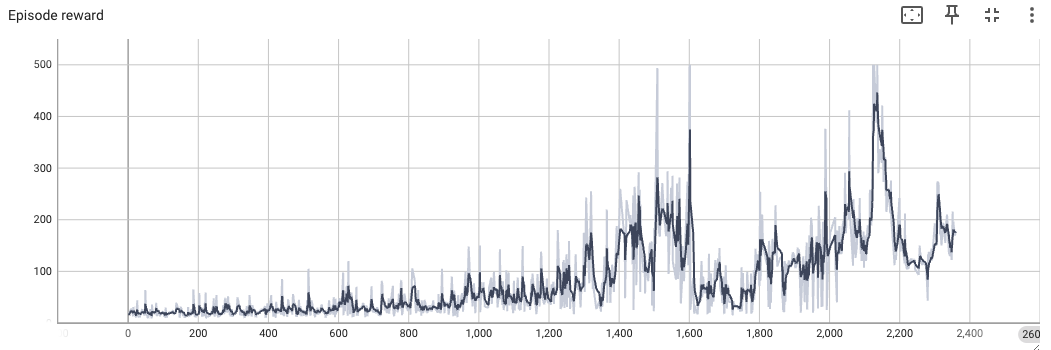

#### Maximum reward:
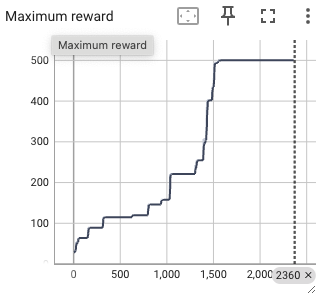